In [36]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import scipy.stats
from sklearn.decomposition import FastICA, PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection

In [37]:
from data_helpers.wine_quality_data_helper import load_wine_quality_data
from data_helpers.mnist_data_helper import load_mnist_data

In [38]:
class ICAWrapper:
    NAME = 'ICA'
    def __init__(self, n_components) -> None:
        self.model = FastICA(n_components=n_components, max_iter=1000)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)
    
    def transform(self, X):
        return self.model.transform(X)

class PCAWrapper:
    NAME = 'PCA'
    def __init__(self, n_components) -> None:
        self.model = PCA(n_components=n_components)

    def fit(self, X):
        return self.model.fit(X)

    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)

class RPWrapper:
    NAME = 'RP'
    def __init__(self, n_components) -> None:
        self.model = GaussianRandomProjection(n_components=n_components)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)

    def get_reconstruction_error(self, X):
        X_star = self.model.fit_transform(X)
        X_reconstructed = self.model.inverse_transform(X_star)
        return np.mean(np.square(X - X_reconstructed))
    
class LLEWrapper:
    NAME = 'LLE'
    def __init__(self, n_components) -> None:
        self.model = LocallyLinearEmbedding(n_components=n_components, n_neighbors=10)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)
    
    def transform(self, X):
        return self.model.transform(X)
    
    def get_reconstruction_error(self):
        return self.model.reconstruction_error_

In [39]:
# DATASET_NAME = 'mnist'
DATASET_NAME = 'wine_quality'

METHOD = ICAWrapper
K_FOLDS = 5
SAVE = True

In [40]:
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X, y, _, _ = load_wine_quality_data()
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X, y, _, _ = load_mnist_data()
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

if DATASET_NAME == 'mnist':
    n = 5000
    X = X[:n]
    y = y[:n]

In [41]:
df_path = f'results/{DATASET_NAME}/{METHOD.NAME}_metrics.csv'
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
    df.set_index('num_components', inplace=True)
    df['num_components'] = df.index
else:
    df = pd.DataFrame()

In [42]:
n = X.shape[0] // K_FOLDS

if DATASET_NAME == 'wine_quality':
    range_ = range(2, 12)
elif DATASET_NAME == 'mnist':
    range_ = [2, 5, 10, 25, 50, 75, 100]
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

for components in tqdm(range_):
    if components in df.index:
        continue
    print(components)
    training_time_list = []
    evaluation_time_list = []
    kurtosis_list = []
    reconstruction_error_list = []
    acc_list = []
    for i in range(K_FOLDS):
        X_train = np.concatenate([X[:i * n], X[(i + 1) * n:]])
        y_train = np.concatenate([y[:i * n], y[(i + 1) * n:]])
        X_test = X[i * n:(i + 1) * n]
        y_test = y[i * n:(i + 1) * n]

        model = METHOD(components)
        t0 = time.perf_counter()
        X_train_star = model.fit_transform(X_train)
        t1 = time.perf_counter()
        training_time_list.append(t1 - t0)

        t0 = time.perf_counter()
        X_test_star = model.transform(X_test) 
        t1 = time.perf_counter()
        evaluation_time_list.append(t1 - t0)

        if DATASET_NAME == 'mnist':
            knn = KNeighborsClassifier(n_neighbors=3)
            knn.fit(model.transform(X_train), y_train)
            acc_knn = knn.score(model.transform(X_test), y_test)
            acc_list.append(acc_knn)
        elif DATASET_NAME == 'wine_quality':
            # run KNN regression
            knn = KNeighborsRegressor(n_neighbors=3)
            knn.fit(model.transform(X_train), y_train)
            knn_pred = knn.predict(model.transform(X_test))
            # get loss
            loss = np.mean(np.square(knn_pred - y_test))
            acc_list.append(loss)

        if METHOD == ICAWrapper:
            # calculate kurtosis using X_test_star
            kurtosis = scipy.stats.kurtosis(X_test_star, axis=0)
            kurtosis_list.append(kurtosis)

        if METHOD == RPWrapper:
            error = model.get_reconstruction_error(X_test)
            reconstruction_error_list.append(error)

        if METHOD == LLEWrapper:
            error = model.get_reconstruction_error()
            reconstruction_error_list.append(error)

    df.loc[components, 'num_components'] = components
    df.loc[components, 'training_time_mean'] = np.mean(training_time_list)
    df.loc[components, 'training_time_std'] = np.std(training_time_list)
    df.loc[components, 'evaluation_time_mean'] = np.mean(evaluation_time_list)
    df.loc[components, 'evaluation_time_std'] = np.std(evaluation_time_list)

    if DATASET_NAME == 'mnist':
        df.loc[components, 'accuracy_mean'] = np.mean(acc_list)
        df.loc[components, 'accuracy_std'] = np.std(acc_list)
    elif DATASET_NAME == 'wine_quality':
        df.loc[components, 'mse_mean'] = np.mean(acc_list)
        df.loc[components, 'mse_std'] = np.std(acc_list)

    if METHOD == RPWrapper or METHOD == LLEWrapper:
        df.loc[components, 'reconstruction_error_mean'] = np.mean(reconstruction_error_list)
        df.loc[components, 'reconstruction_error_std'] = np.std(reconstruction_error_list)
    if METHOD == ICAWrapper:
        df.loc[components, 'kurtosis_mean'] = np.mean(kurtosis_list)
        df.loc[components, 'kurtosis_std'] = np.std(kurtosis_list)

100%|██████████| 10/10 [00:00<00:00, 156503.88it/s]


In [43]:
if SAVE:
    os.makedirs(os.path.dirname(df_path), exist_ok=True)
    df.to_csv(df_path, index=False)

In [44]:
if DATASET_NAME == 'mnist':
    components = 196
    # components = 40
elif DATASET_NAME == 'wine_quality':
    components = 11

(array([7., 2., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([ -0.778577  ,  37.79863985,  76.37585671, 114.95307356,
        153.53029041, 192.10750727, 230.68472412, 269.26194097,
        307.83915782, 346.41637468, 384.99359153]),
 <BarContainer object of 10 artists>)

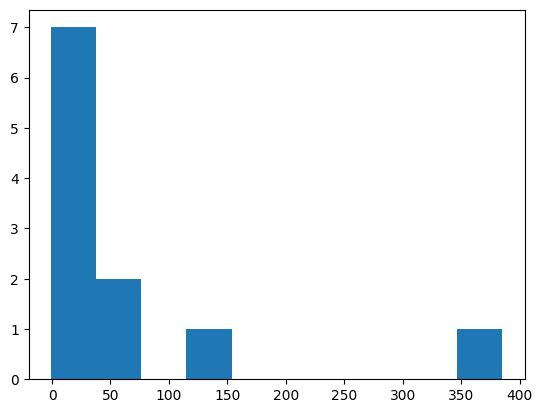

In [45]:
import matplotlib.pyplot as plt
model = ICAWrapper(components)
n = X.shape[0]//2
model.fit(X[:n])
X_star = model.transform(X[n:])
kurt = scipy.stats.kurtosis(X_star, axis=0)
plt.hist(kurt)

In [46]:
K_FOLDS = 2
n = 1000
X = X[:n]
y = y[:n]
n = X.shape[0] // K_FOLDS
scores_list = []
c_list = []
for i in range(K_FOLDS):
    X_train = np.concatenate([X[:i * n], X[(i + 1) * n:]])
    y_train = np.concatenate([y[:i * n], y[(i + 1) * n:]])
    X_test = X[i * n:(i + 1) * n]
    y_test = y[i * n:(i + 1) * n]
    model = FastICA(n_components=components, max_iter=1000)
    X_train_star = model.fit_transform(X_train)
    print('ICA fit done')
    kurtosis = scipy.stats.kurtosis(X_train_star, axis=0)
    scores = []
    c = []
    for i in tqdm(range(0, components)):
        thresh = np.sort(kurtosis)[::-1][i]
        mask = kurtosis <= thresh
        c.append(sum(mask))
        X_train_star = model.transform(X_train)[:, mask]
        X_test_star = model.transform(X_test)[:, mask]
        if DATASET_NAME == 'mnist':
            knn = KNeighborsClassifier(n_neighbors=3)
            knn.fit(X_train_star, y_train)
            acc_knn = knn.score(X_test_star, y_test)
            scores.append(acc_knn)
        elif DATASET_NAME == 'wine_quality':
            # run KNN regression
            knn = KNeighborsRegressor(n_neighbors=3)
            knn.fit(X_train_star, y_train)
            knn_pred = knn.predict(X_test_star)
            # get loss
            loss = np.mean(np.square(knn_pred - y_test))
            scores.append(loss)
    c_list.append(c)
    scores_list.append(scores)

ICA fit done


100%|██████████| 11/11 [00:00<00:00, 82.78it/s]


ICA fit done


100%|██████████| 11/11 [00:00<00:00, 491.60it/s]


In [47]:
for c in c_list:
    for i,val in enumerate(c):
        assert(c_list[0][i] == val)
c = c_list[0]
c

[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [48]:
means = []
stds = []
for i in range(len(scores_list[0])):
    s = []
    for j in range(K_FOLDS):
        s.append(scores_list[j][i])
    means.append(np.mean(s))
    stds.append(np.std(s))

/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_2/ica_wine_quality_mse_kurt.png


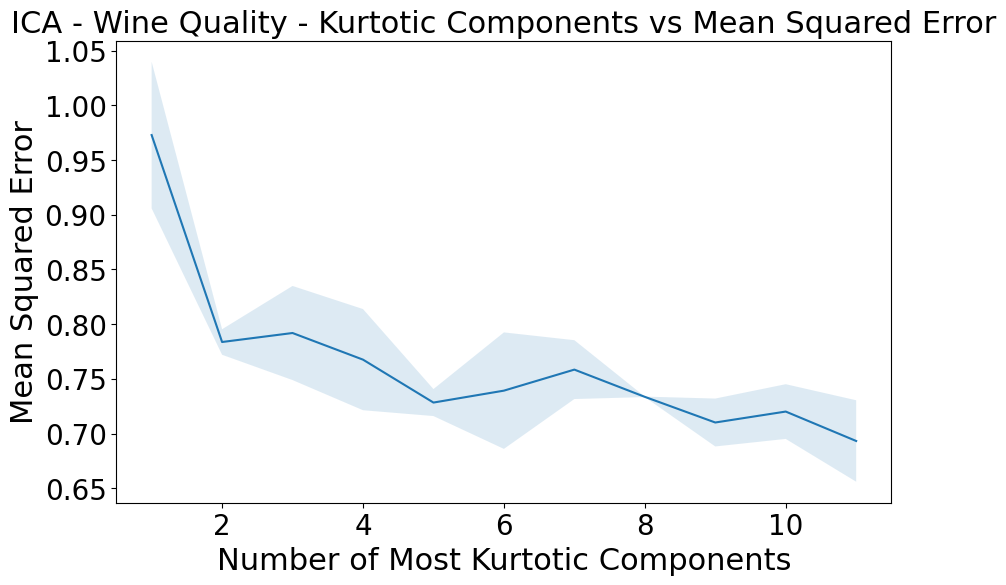

In [50]:
if DATASET_NAME == 'mnist':
    METRIC = 'accuracy'
    METRIC_STR = 'Accuracy'
elif DATASET_NAME == 'wine_quality':
    METRIC = 'mse'
    METRIC_STR = 'Mean Squared Error'

fontsize=22
plt.figure(figsize=(10,6))
plt.title(f'ICA - {DATASET_STR} - Kurtotic Components vs {METRIC_STR}', fontsize=fontsize)
plt.xlabel('Number of Most Kurtotic Components', fontsize=fontsize)
plt.ylabel(METRIC_STR, fontsize=fontsize)
plt.plot(c, means)
plt.fill_between(
    c, 
    np.array(means)-np.array(stds), 
    np.array(means)+np.array(stds), 
    alpha=0.15)
# plt.savefig(f'figures/{DATASET_NAME}_{METHOD.NAME}_kurtosis_vs_mse.png')

plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)

# plt.ylim(0.7, 0.9)

path = (f'/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_2/'+
        f'{METHOD.NAME.lower()}_{DATASET_NAME.lower()}_{METRIC.lower()}_kurt.png')
print(path)
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path, bbox_inches='tight')
